# Preprocessing and Feature Extraction

[Reading the dataset folders](#Reading-the-dataset-folders):
- KAP, the dataset that contains events from 3 kinetic-augmented bases "NA", "R1", "M1"
- NO_KAA, the dataset that contains events from 3 different pill bottles without augmentation "B1", "B2", "B3"

[Preprocessing each event](#Preprocessing-each-event):
- We normalize based on the greatest peak of each event detected
- We isolate a frequency band between 500 Hz - 600 Hz

[Feature Extraction](#Feature-Extraction):
- energy decay, in the form of clamped peak count at different amplitude levels
- peak interval comparing the first 3 peaks

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from pathlib import Path

# map for folder and file locations
input_files = {"KAA/raw_old": ((("KAA","npy"),),("NA", "R1", "M1"),("middle", "topright", "bottomright", "bottomleft", "topleft")),
              "NO_KAA/raw": ((("no_KAA","mat"),),("B1", "B2", "B3"),("middle", "topright", "bottomright", "bottomleft", "topleft"))
              }

## Reading the dataset folders

In [12]:
# read all data
data = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        print(pers_name)
        data[pers_name] = dict()
        for loc in locs:
            data[pers_name][loc] = dict()
            for aug in augs:
                if filetype == "npy":
                    data[pers_name][loc][aug] = np.load(f"./{folder}/{pers_name}_{aug}_{loc}.npy")
                elif filetype == "mat":
                    _arr = loadmat(f"./{folder}/{pers_name}_{aug}_{loc}.mat")
                    data[pers_name][loc][aug] = np.array([x[0] for x in _arr["filteredEvents"].flatten()])
                elif filetype == "csv":
                    data[pers_name][loc][aug] = np.loadtxt(f"./{folder}/{pers_name}_{aug}_{loc}.csv", delimiter=',')
                # print(data[pers_name][loc][aug])

KAA
no_KAA


### Example Raw signal Events

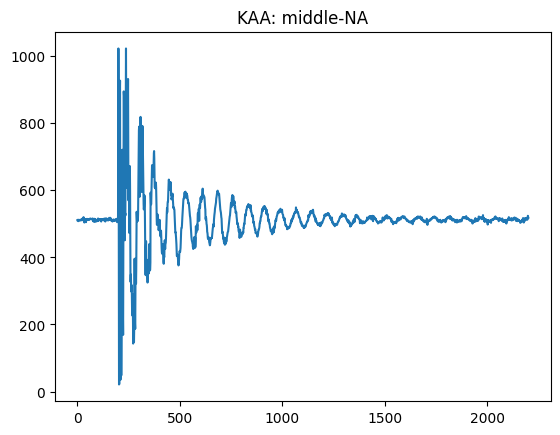

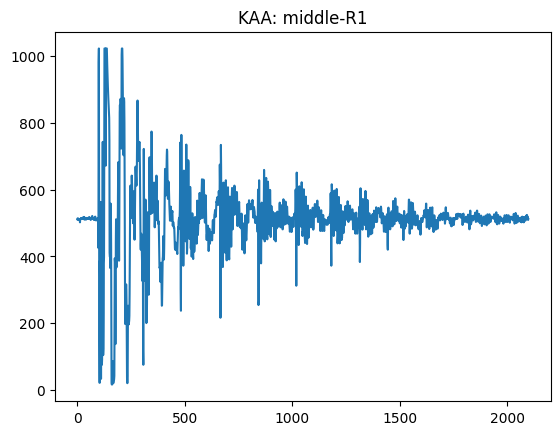

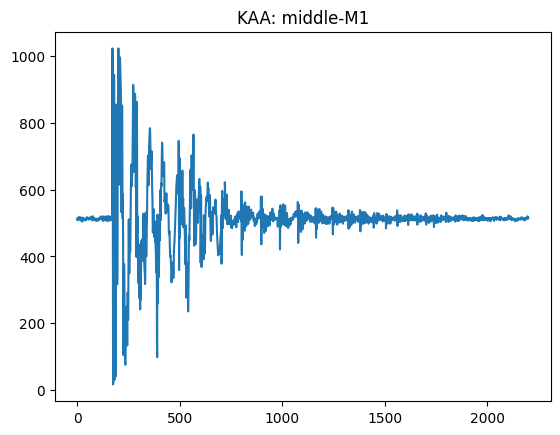

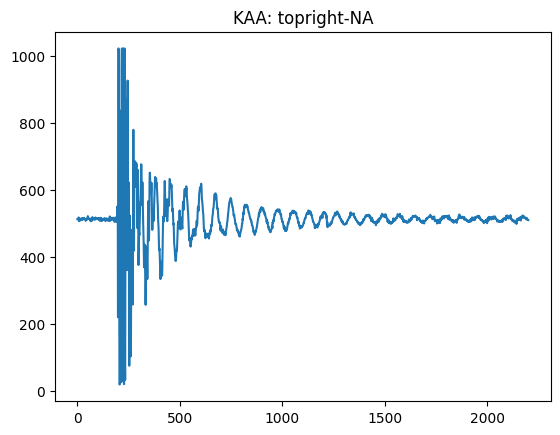

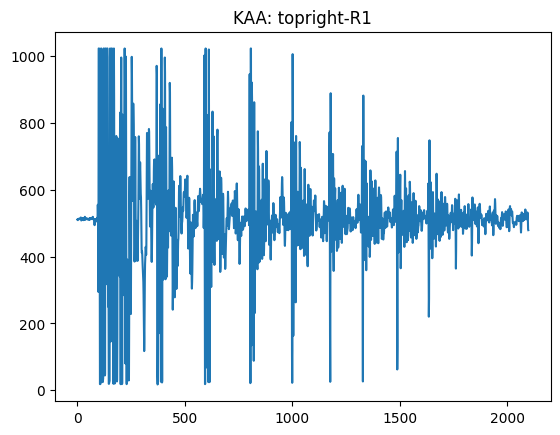

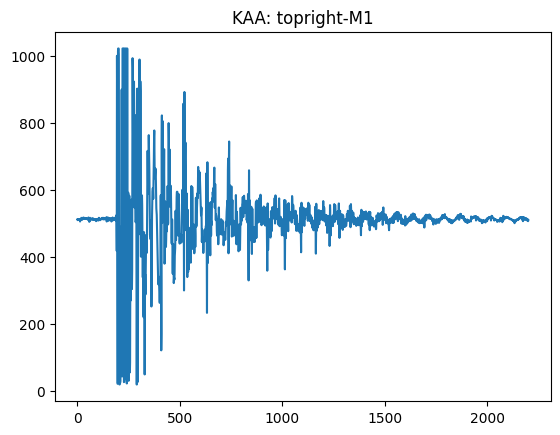

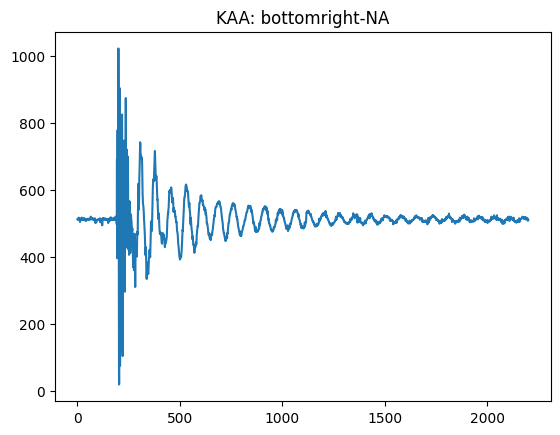

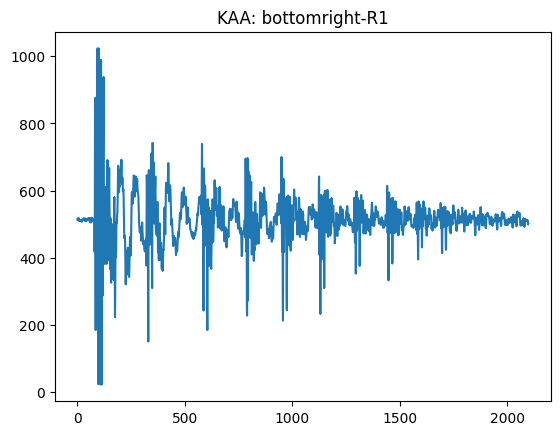

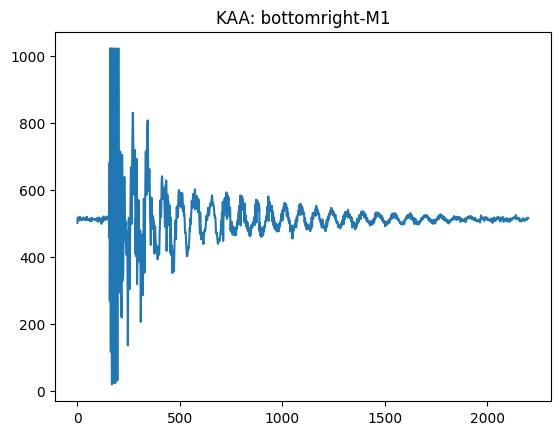

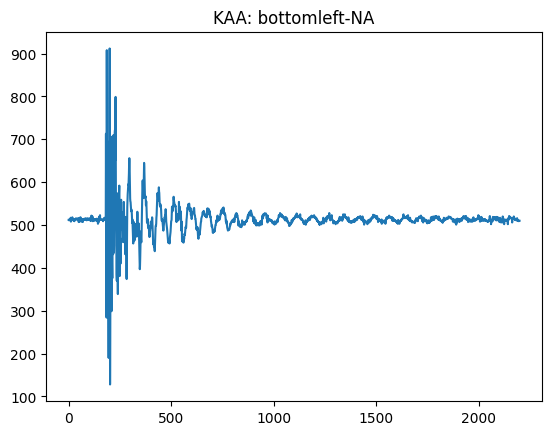

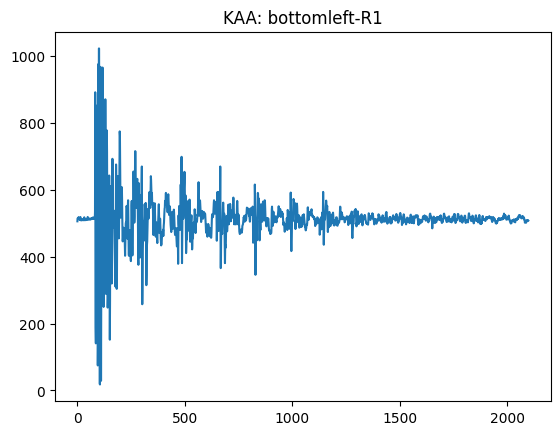

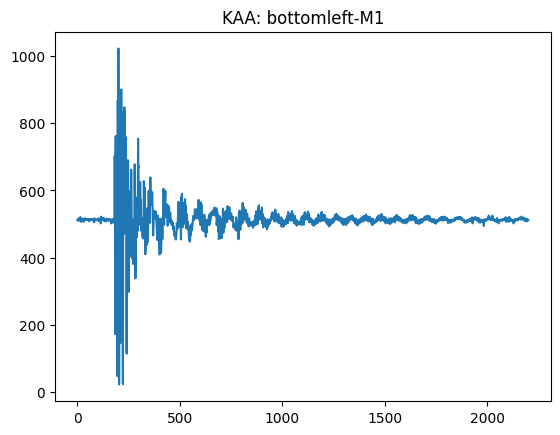

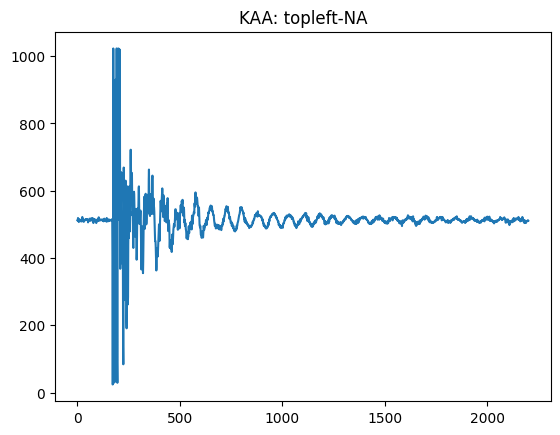

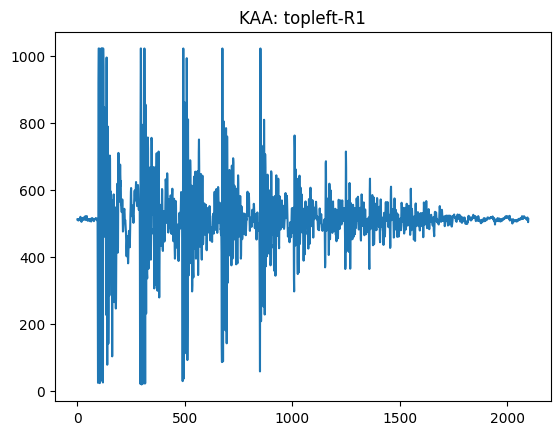

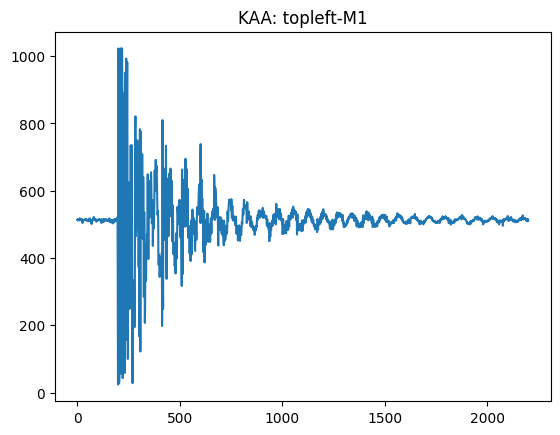

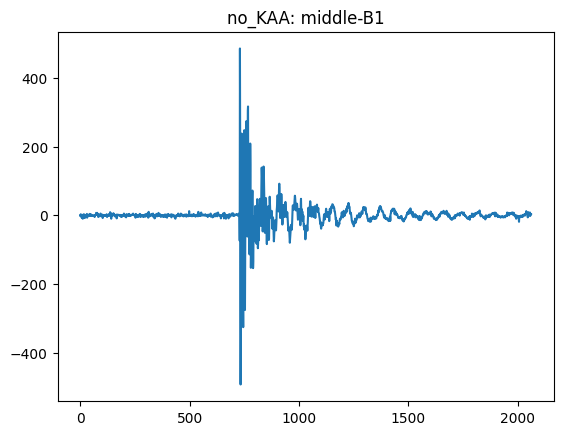

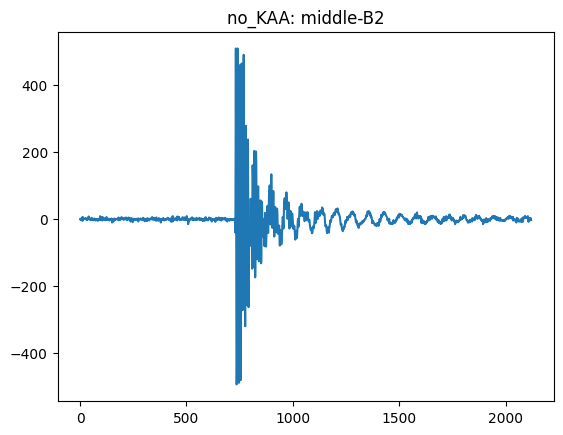

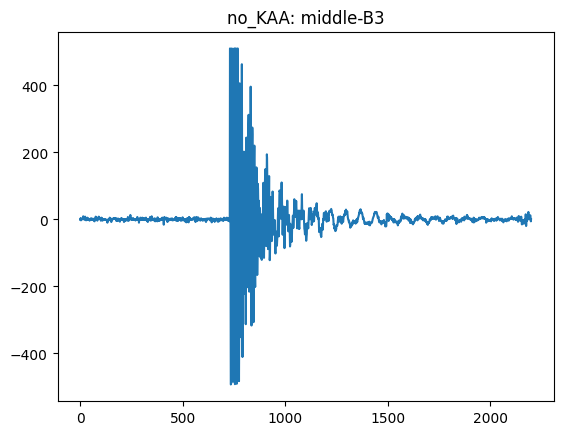

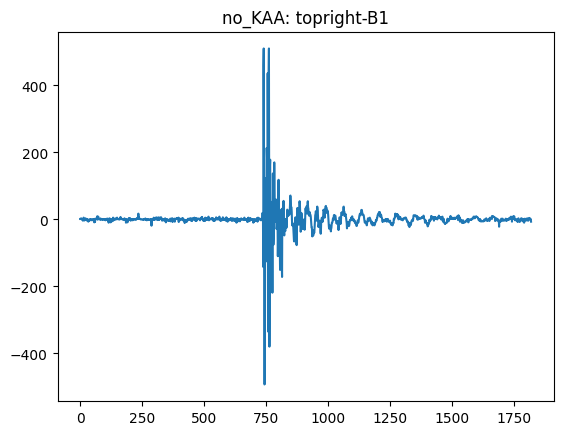

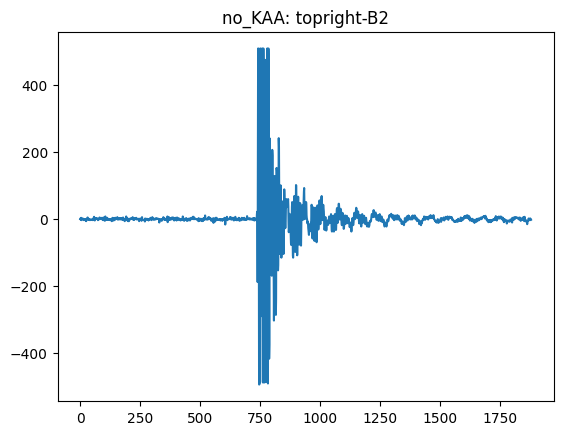

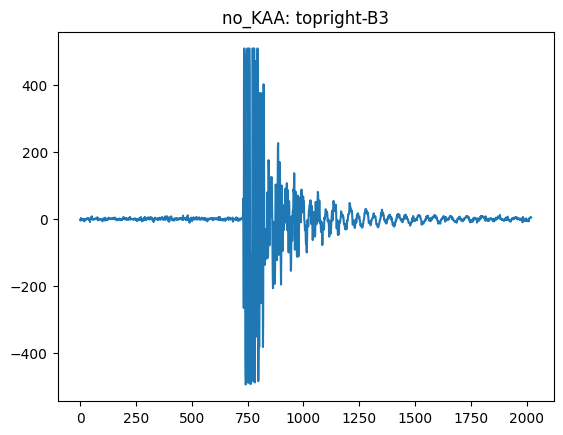

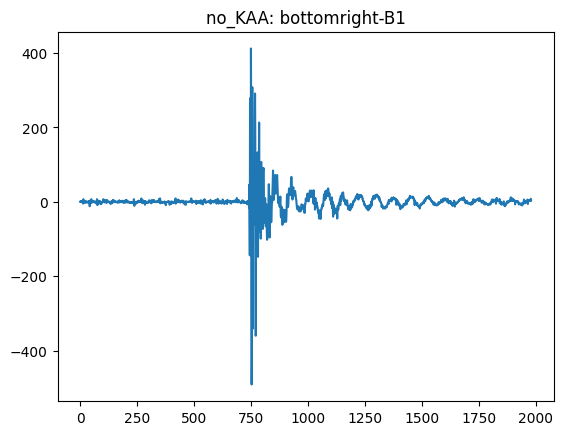

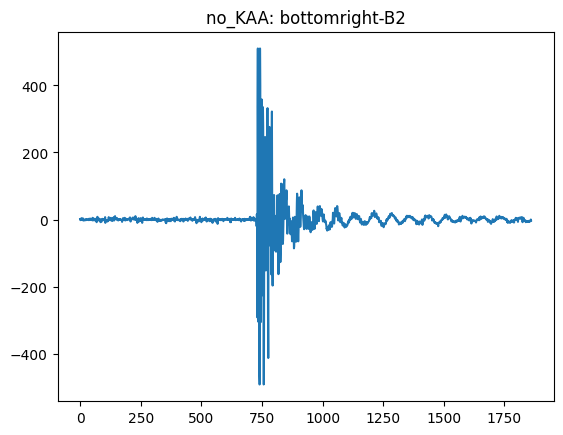

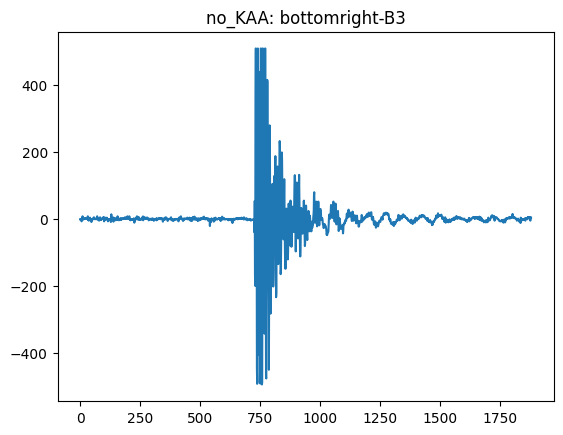

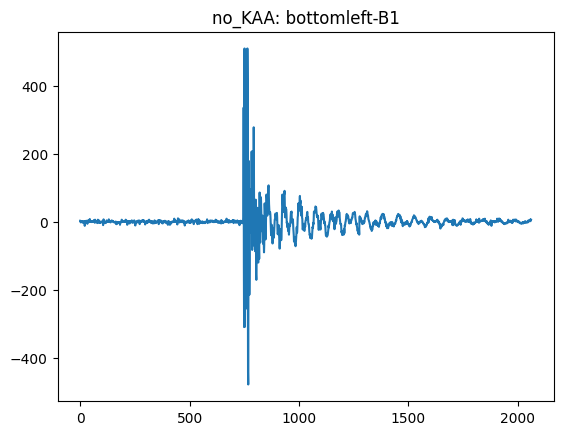

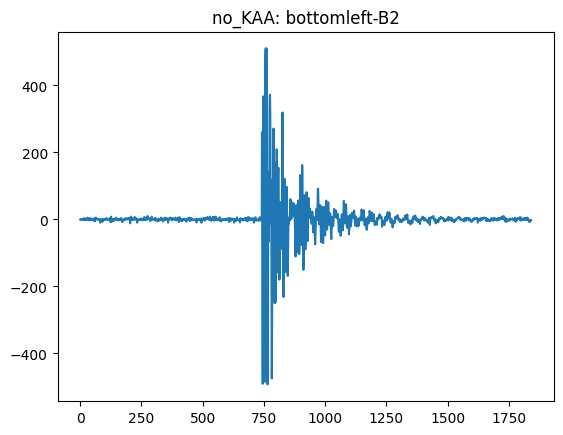

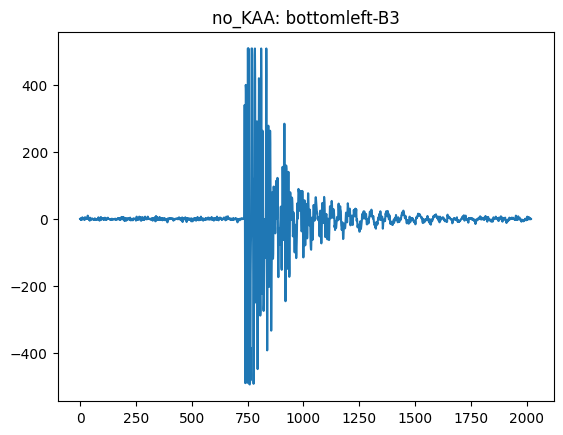

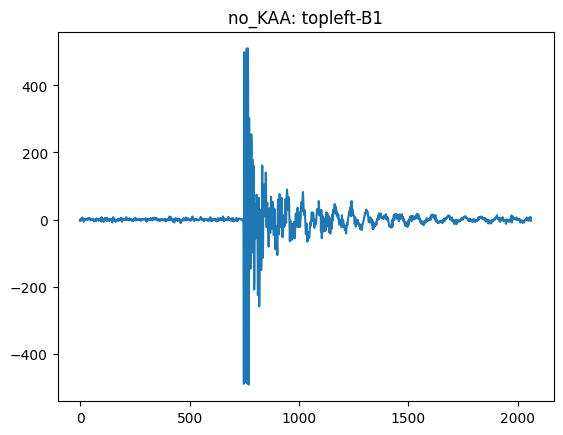

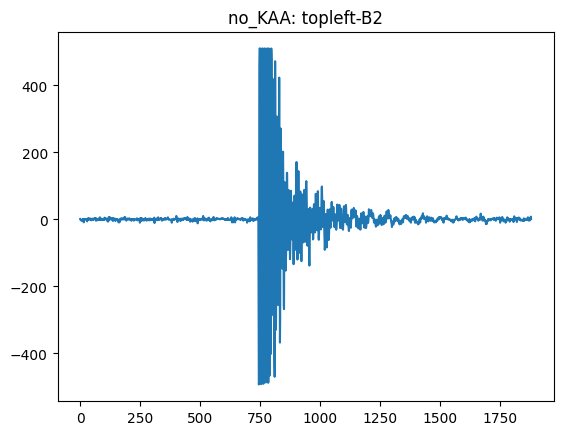

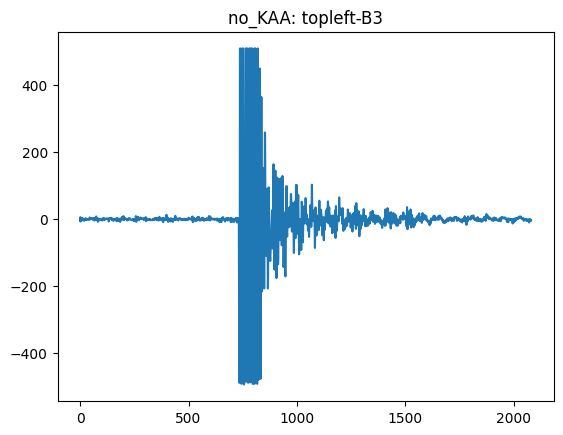

In [13]:
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        for loc in locs:
            for aug in augs:
                ex = data[pers_name][loc][aug][0]
                # print(ex)
                plt.plot(ex)
                plt.title(f"{pers_name}: {loc}-{aug}")
                plt.show()

## Preprocessing each event

In [14]:
from scipy import signal, stats, optimize
from pathlib import Path
preprocessed_data = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        preprocessed_data[pers_name] = dict()
        for loc in locs:
            plot_flag = False
            preprocessed_data[pers_name][loc] = dict()
            for aug in augs:
                _output = list()
                _ffts = list()
                for i in range(len(data[pers_name][loc][aug])):
                    
                    # stft
                    ex = data[pers_name][loc][aug][i]
                    ex = ex - ex.mean()

                    
                    
                    # save fft
                    # _ffts.append(np.fft.fft(ex, n=1175))
                    # normalize raw signal
                    eng = np.sqrt(np.sum(ex**2))
                    ex = ex / eng
                    tmp_fft = np.fft.fft(ex, n = 2350)
                    abs_fft = np.abs(tmp_fft)
                    _ffts.append(abs_fft[:1174])

                    if plot_flag:
                        print(np.array(abs_fft[:1174]).shape)
                        plot_flag = False
                    
                    # stft
                    f, t, Zxx = signal.stft(ex,2400, nperseg=25)
                    Zxx = np.abs(Zxx)
                    # save stft
                    # stft_dir = Path(f"{folder}/stft/")
                    # if not stft_dir.exists():
                    #     stft_dir.mkdir()
                    # np.savetxt(f"{folder}/stft/{pers_name}_{aug}_{loc}_f_{i}.csv", f)
                    # np.savetxt(f"{folder}/stft/{pers_name}_{aug}_{loc}_Zxx_{i}.csv", Zxx)
                    
                    # plt.plot(ex)
                    # plt.show()
                    # print(ex)
                    # print(f.shape,t.shape,Zxx.shape)
                    
                    # band pass 500 Hz - 600 Hz
                    band = np.where(np.logical_and(f > 700, f < 800))
                    # band = np.where(np.logical_and(f >= 200, f <= 600))
                    f_band_pass = f[band]
                    Zxx_band_pass = Zxx[band]
                    # print(f)
                    
                    
                    # moving average for filtering
                    def moving_average(a, n=3):
                        ret = np.cumsum(a, dtype=float)
                        ret[n:] = ret[n:] - ret[:-n]
                        return ret[n - 1:] / n
                    # print(ex.shape, Zxx_band_pass.shape)
                    Zxx_band_pass = moving_average(Zxx_band_pass[0], n=3)
        
                    # get abs
                    Zxx_band_pass = np.abs(Zxx_band_pass)
            
                    # set to normalized scale
                    exp = np.max(Zxx_band_pass)
                    Zxx_band_pass = Zxx_band_pass / exp

                    # saved to preprocessed_data
                    _output.append(Zxx_band_pass)
                preprocessed_data[pers_name][loc][aug] = _output
                # print(np.array(_ffts).shape)
                np.save(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy", _ffts)
                # print(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy")

In [5]:
'''input_files = {"KAA/fft": ((("KAA","csv"),),("NA", "R1", "M1"),("middle", "topright", "bottomright", "bottomleft", "topleft")),
              "NO_KAA/fft": ((("no_KAA","csv"),),("B1", "B2", "B3"),("middle", "topright", "bottomright", "bottomleft", "topleft"))
              }
# fft = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        for loc in locs:
            for aug in augs:
                ex = np.loadtxt(f"./{folder}/{pers_name}_{aug}_{loc}.csv", delimiter=',')
                # print(ex.shape)
                np.save(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy", ex)
                '''

'input_files = {"KAA/fft": ((("KAA","csv"),),("NA", "R1", "M1"),("middle", "topright", "bottomright", "bottomleft", "topleft")),\n              "NO_KAA/fft": ((("no_KAA","csv"),),("B1", "B2", "B3"),("middle", "topright", "bottomright", "bottomleft", "topleft"))\n              }\n# fft = dict()\nfor folder,info in input_files.items():\n    ppl, augs, locs = info\n    for pers in ppl:\n        pers_name, filetype = pers\n        for loc in locs:\n            for aug in augs:\n                ex = np.loadtxt(f"./{folder}/{pers_name}_{aug}_{loc}.csv", delimiter=\',\')\n                # print(ex.shape)\n                np.save(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy", ex)\n                '

### Example Preprocessed signal Events

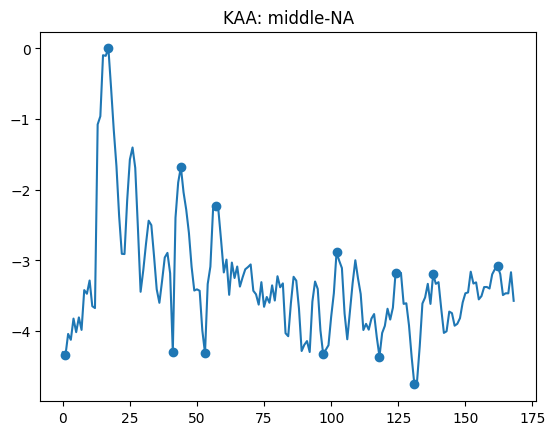

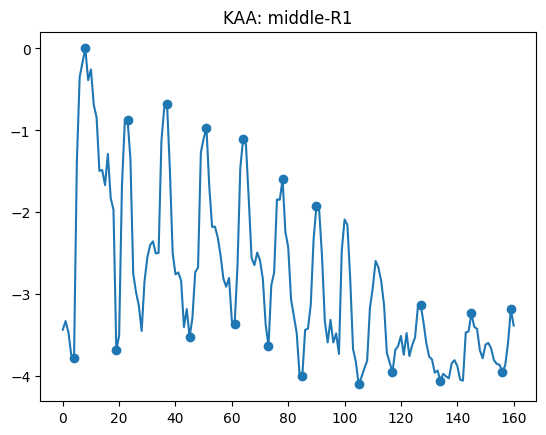

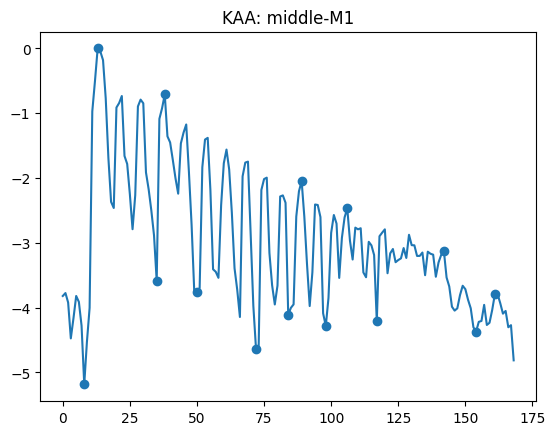

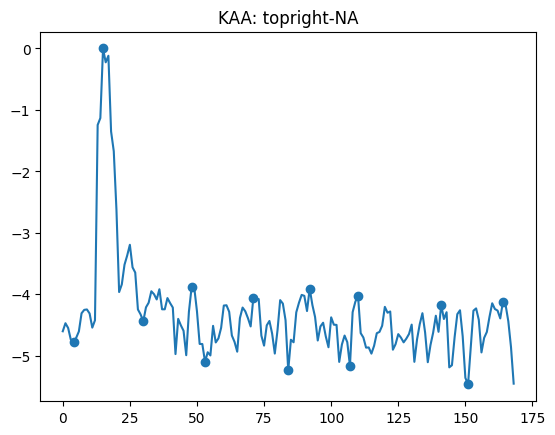

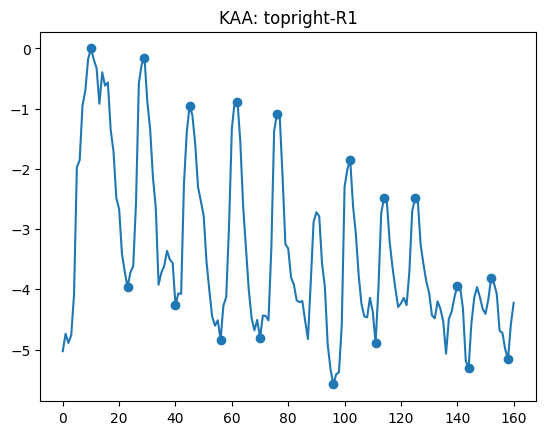

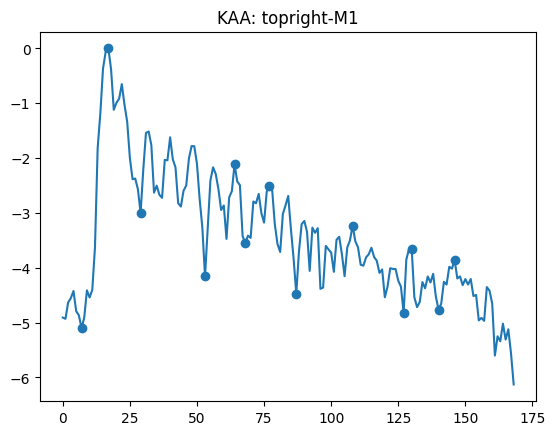

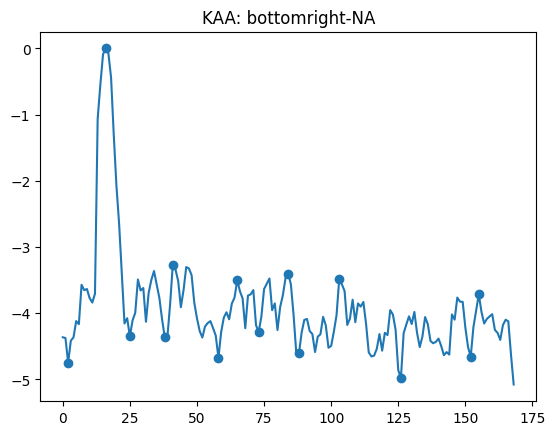

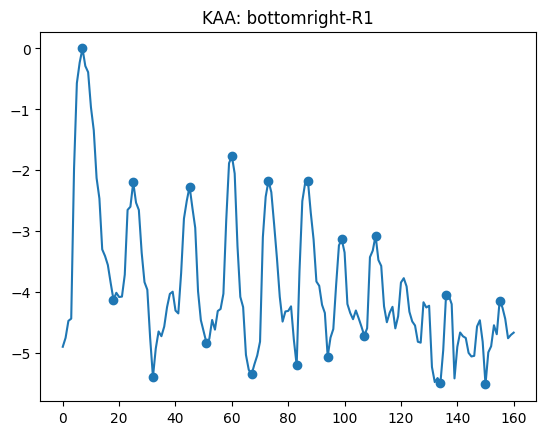

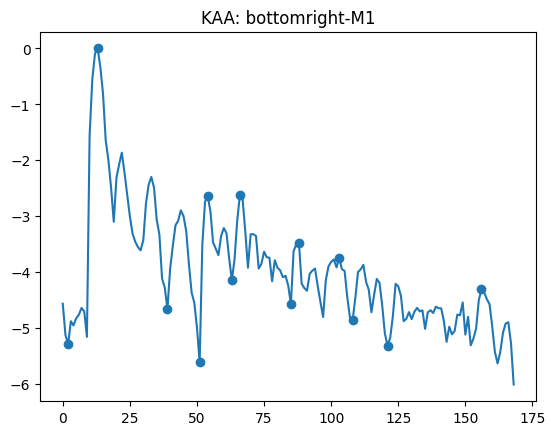

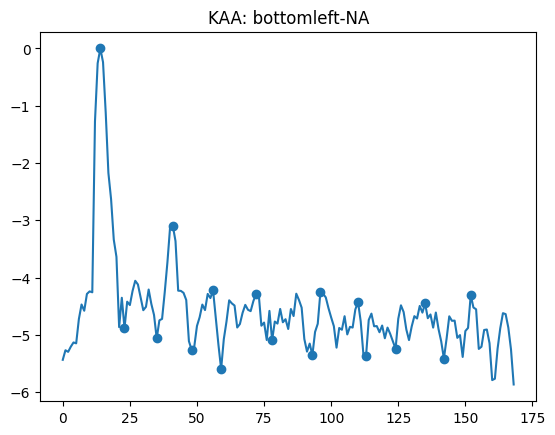

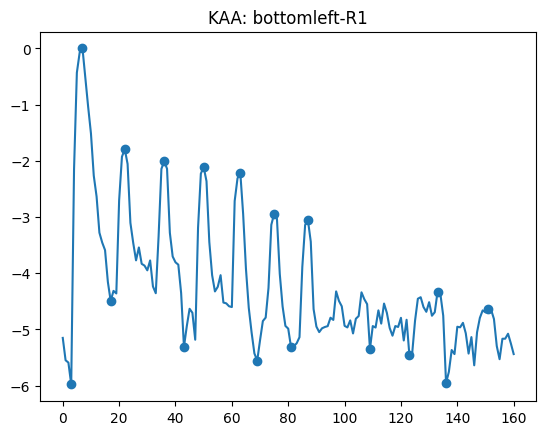

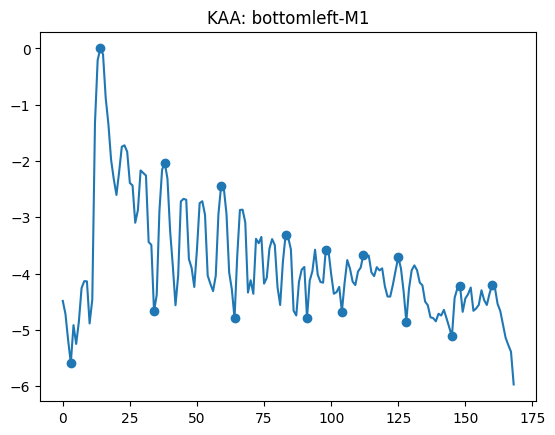

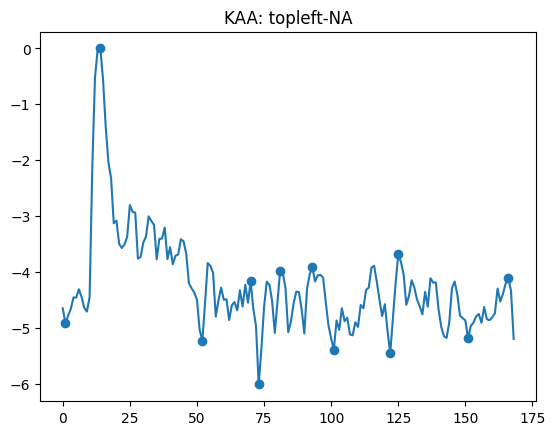

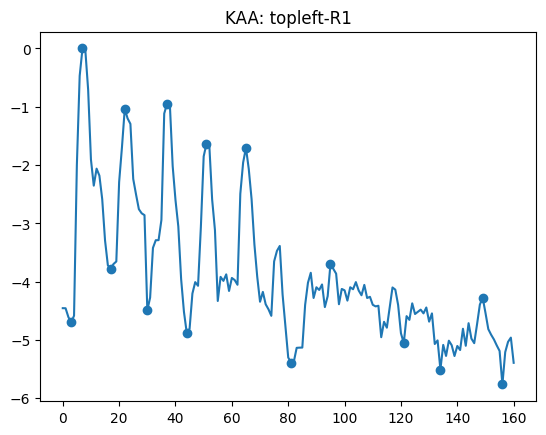

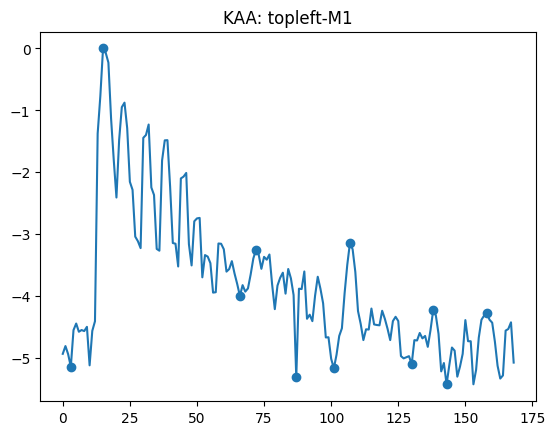

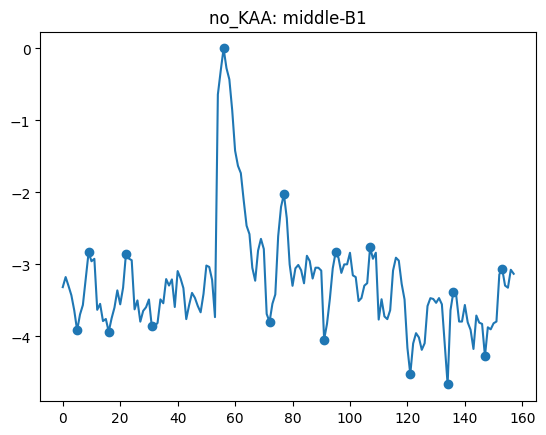

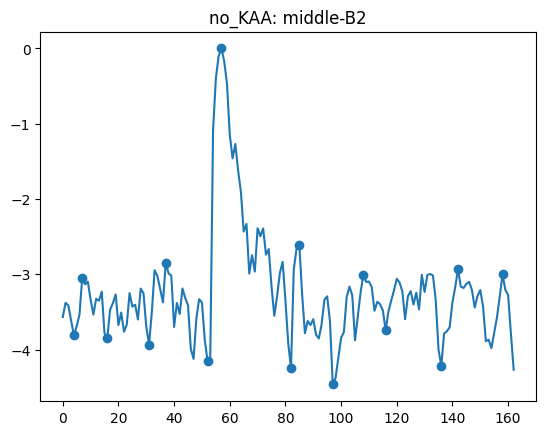

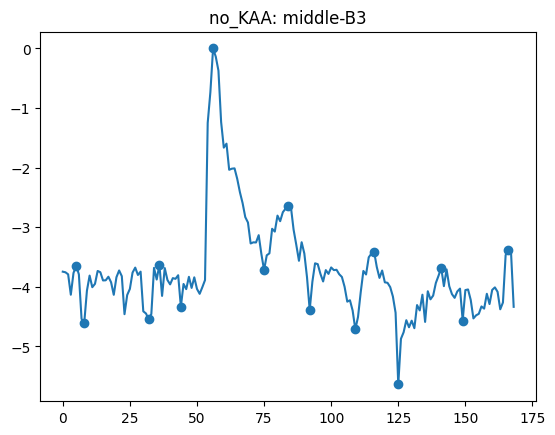

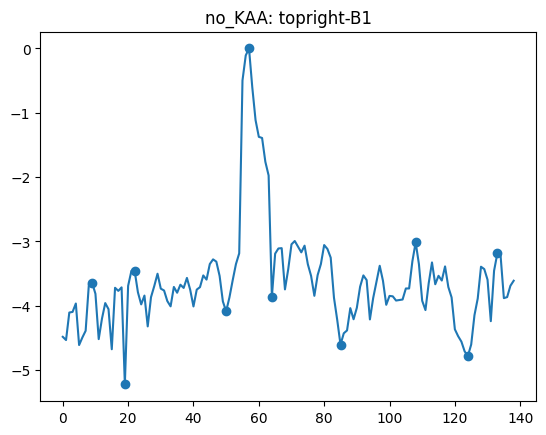

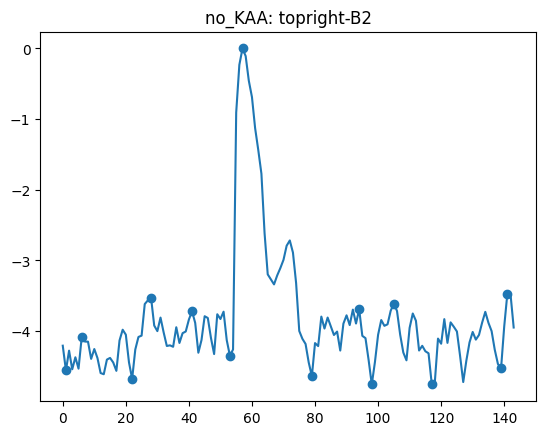

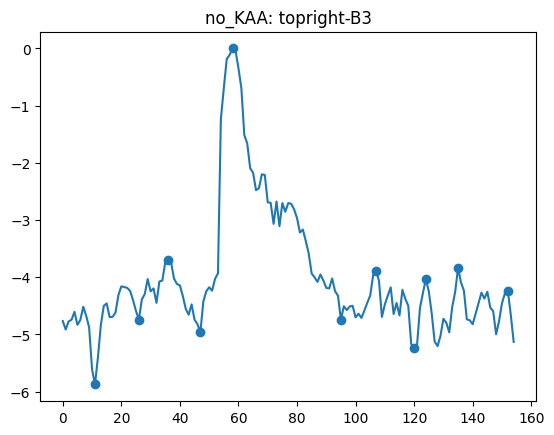

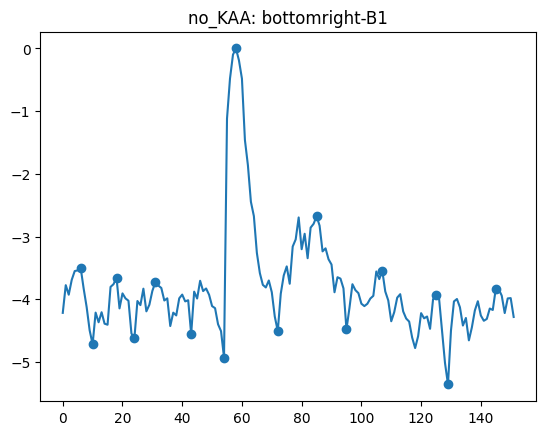

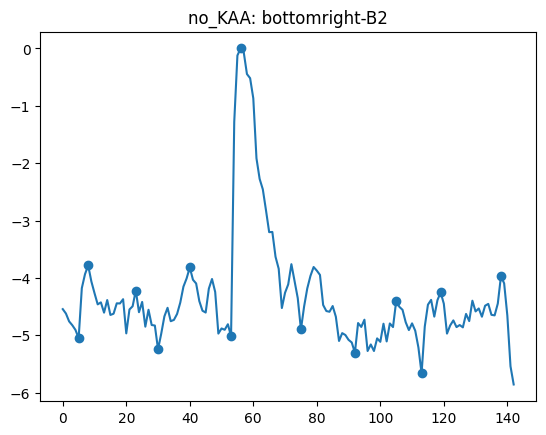

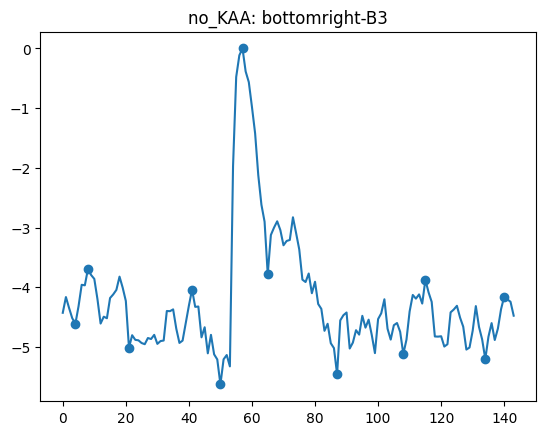

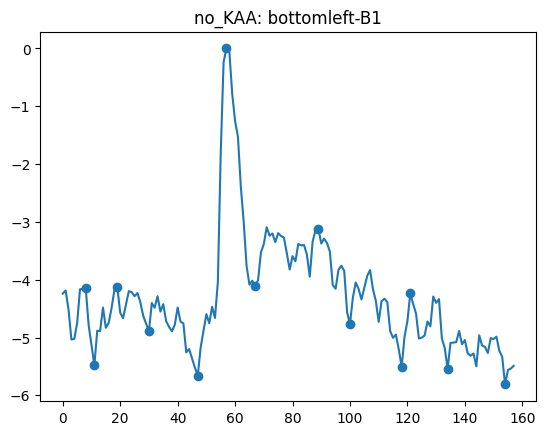

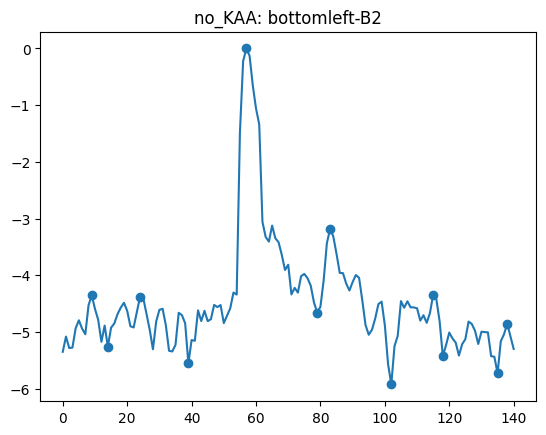

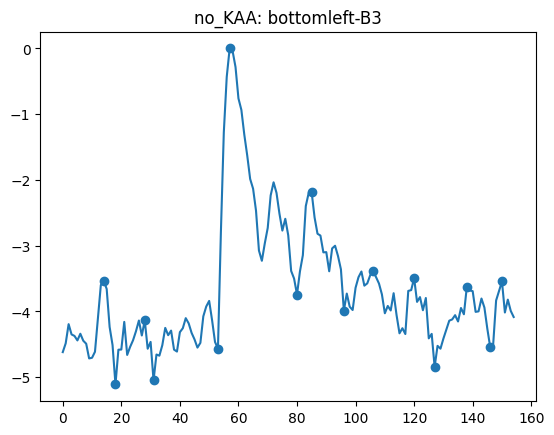

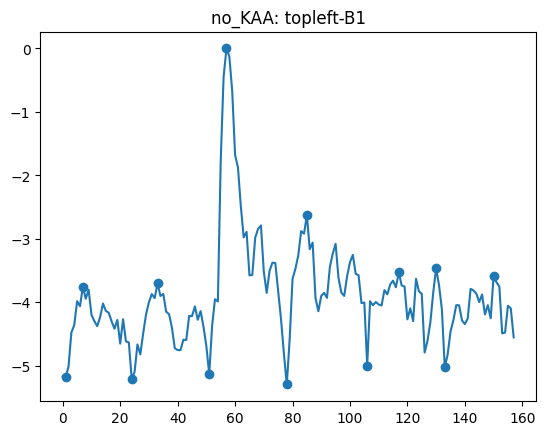

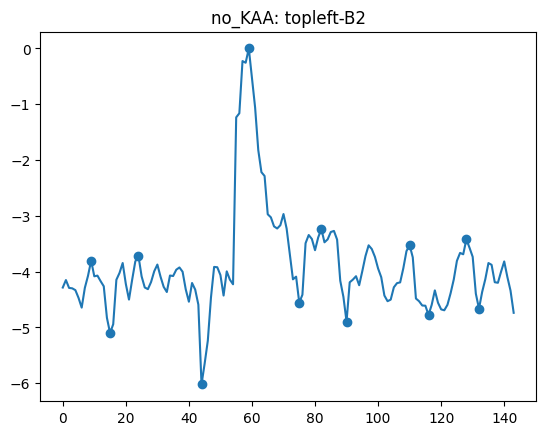

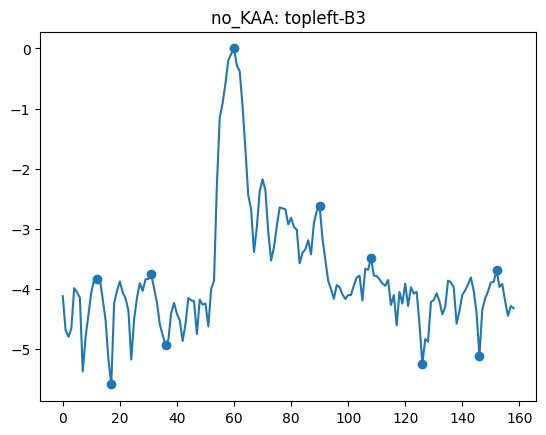

In [15]:
# print(preprocessed_data)
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        for loc in locs:
            for aug in augs:
                ex = preprocessed_data[pers_name][loc][aug][0]
                # print(ex)
                ll = np.log(ex)
                plt.plot(ll)
                # ll = np.log(event)
                llX = np.concatenate((signal.argrelmax(ll, order=10),signal.argrelmin(ll, order=10)), axis=None)
                lly = ll[llX]
                plt.scatter(llX, lly)
                plt.title(f"{pers_name}: {loc}-{aug}")
                plt.show()

## Feature Extraction

In [16]:
# helper functions
from scipy import signal, stats
# def get_ultra_smooth_line_fit(event, debug=None):
#     def moving_average(a, n=3):
#         ret = np.cumsum(a, dtype=float)
#         ret[n:] = ret[n:] - ret[:-n]
#         return ret[n - 1:] / n
#     smoothed_event = moving_average(event, n=20)
    
#     min = signal.argrelmin(data, order=10)

def get_lin_fit(event, debug=None):
    ll = np.log(event)
    llX = signal.argrelmax(ll, order=10)
    lly = ll[llX]
    res1 = stats.linregress(llX, lly)

    llX = signal.argrelmin(ll, order=10)
    lly = ll[llX]
    res2 = stats.linregress(llX, lly)
    
    debug[loc][aug].append(res1.slope)
    debug[loc][aug].append(res2.slope)
    return (res1.slope, res2.slope)
    # return (res1.slope,)
    # return (res2.slope,)
    
def get_simplified_fft(event, debug=None):
    _fft = np.abs(np.fft.fft(event, n=200)[5:100]**2)
    # plt.plot(_fft)
    # plt.show()
    debug[loc][aug].append(max(range(95), key=lambda x: _fft[x]))
    return sorted(range(95), key=lambda x: _fft[x], reverse=True)[:2]
    # smooth_event = moving_average(Zxx_band_pass[0], n=3)

def get_clamped_peak_counts(event, clamp_value=2, debug=None):
    ''' get clamped peak count features, never going over the clamp_value

        return iterator(int)
    '''

    # # store a list of clampled values greater than 1
    cl_values = list()
    # ranges from 20% of max peak amplitude to 80% max peak amplitude (inclusive)
    # def moving_average(a, n=3):
    #     ret = np.cumsum(a, dtype=float)
    #     ret[n:] = ret[n:] - ret[:-n]
    #     return ret[n - 1:] / n
    # smoothed_event = moving_average(event, n=2)
    # plt.plot(smoothed_event)
    # plt.show()
    
    # example: one event 0.2, 0.4, 0.6
    # select different peak threshholds
    clamped_values = list()
    for i in np.arange(0.2,1,0.2):
        peaks_y = list(signal.find_peaks(event, height=i, distance=5)[1]["peak_heights"])
        # peaks_X = signal.argrelmax(smoothed_event, order=10)[0]
        # peaks_y = [event[x] for x in peaks_X]
        # print(peaks_X)

        # processing starting of the signal
        if event[0] > 0.1:
            peaks_y.append(0)
            peaks_y.append(event[0])
        # peaks_X = np.array(signal.find_peaks(event, height=i, distance=5)[0])
        # peaks_X2 = peaks_X[sorted(range(len(peaks_X)), key=lambda x: peaks_y[x], reverse=True)]
        
        # clamped_value = len(peaks_y[:clamp_value])
        # clamp value
        clamped_value = min(clamp_value, len(peaks_y))
        if (debug is not None) and clamped_value > 1:
            cl_values.append(i)
            debug[loc][aug].append(i)

        # check to see if i is divisible by 2
        # im = i * 10 / 2
        # if abs(int(im) - im) < 0.01:
        clamped_values.append(clamped_value)
    # peaks_y = sorted(list(signal.find_peaks(event, height=0.05, distance=5)[1]["peak_heights"]), reverse=True)
    # yield 20 if len(peaks_y) < 2 else peaks_y[0] / peaks_y[1]
    # return median threshhold
    clamped_values.append(0 if len(cl_values) == 0 else sorted(cl_values)[len(cl_values) // 2])
    return clamped_values


def get_peaks(event):
    '''get indices and amplitude of peaks from event

        return peaksx(list(int)), peaksy(list(int))
    '''
    
    # get peaks
    all_x_peaks = list(signal.find_peaks(event, height=0.1, distance=10)[0])
    all_y_peaks = list(event[all_x_peaks])
    if event[0] > 0.1:
        all_x_peaks.append(0)
        all_y_peaks.append(event[0])

    # signal end threshhold
    all_x_peaks.append(len(event))
    all_y_peaks.append(0.1)

    return all_x_peaks, all_y_peaks
def get_peak_amplitude_ratio(event, debug=None):
    ''' get peak amplitude ratio, the first peak divided by the second peak, to estimate energy decay

        return int
    '''
    # get peaks
    _, all_y_peaks = get_peaks(event)
    
    # get first peak ratios
    if len(all_y_peaks) >= 2:
        peak_amplitude_ratio = all_y_peaks[0] / all_y_peaks[1]
    else:
        # default value
        peak_amplitude_ratio = 100
    debug[loc][aug].append(peak_amplitude_ratio)
    return peak_amplitude_ratio

def get_median_peak_amplitude_ratio(event, debug=None):
    ''' get pmedian eak amplitude ratio, the first peak divided by the second peak, to estimate energy decay

        return int
    '''
    # get peaks
    _, all_y_peaks = get_peaks(event)
    
    # get first peak ratios
    peak_amplitude_ratios = list()
    for i in range(len(all_y_peaks) - 1):
        peak_amplitude_ratios.append(all_y_peaks[i] / all_y_peaks[i + 1])
    # else:
    #     # default value
    #     peak_amplitude_ratio = 100
    if len(peak_amplitude_ratios) == 0:
        peak_amplitude_ratio = 100
    else:
        peak_amplitude_ratio = sorted(peak_amplitude_ratios)[len(peak_amplitude_ratios) // 2]
    debug[loc][aug].append(peak_amplitude_ratio)
    return peak_amplitude_ratio

def get_peak_interval(event, debug=None):
    ''' get peak interval, the first 2 peaks averaged or min (in case a bounce was missed), to estimate energy decay

        return int
    '''
    
    # get peaks
    all_x_peaks, _ = get_peaks(event)
    # get first peak intervals
    if len(all_x_peaks) >= 3:
        interval1 = all_x_peaks[1] - all_x_peaks[0] 
    else:
        # default to 20
        interval1 = 20
    debug[loc][aug].append(interval1)
    
    # get second peak intervals
    if len(all_x_peaks) >= 4:
        interval2 = all_x_peaks[2] - all_x_peaks[1]
    else:
        # default to 20
        interval2 = 20
    debug[loc][aug].append(interval2)

    # compare first and second_peak
    if abs(interval2 - interval1) > 10:
        return min(interval2,interval1)
    else:
        return (interval2 + interval1) / 2
        
def get_median_peak_interval_ratio(event, debug=None):
    ''' get median eak interval ratio, the first peak divided by the second peak, to estimate energy decay

        return int
    '''
    # get peaks
    all_x_peaks, _ = get_peaks(event)
    

    # get first peak intervals
    peak_intervals = list()
    for i in range(len(all_x_peaks) - 1):
        peak_intervals.append(all_x_peaks[i + 1] - all_x_peaks[i]) 

    # else:
    #     # default value
    #     peak_amplitude_ratio = 100
    if len(peak_intervals) == 0:
        peak_interval = 200
    else:
        peak_interval = sorted(peak_intervals)[len(peak_intervals) // 2]
    debug[loc][aug].append(peak_interval)
    return peak_interval
    # TODO: average next?


In [10]:
''' retired features (too low accuracy)
# # Zxx_band_pass_m = moving_average(Zxx_band_pass, n=20)
# Zxx_band_pass_m = Zxx_band_pass
# res = stats.linregress(np.arange(len(Zxx_band_pass_m)), Zxx_band_pass_m)
# # get line fit
# # _x = np.arange(0,150,50)
# if not np.isnan(res.slope) and not np.isinf(res.slope):
#     # if res.slope > 0:
#     #     print("ee")
#     n_peaks.append(res.slope * 100)
#     # plt.plot(Zxx_band_pass)
#     # plt.scatter(all_x_peaks,all_y_peaks)
#     # plt.plot(_x, res.intercept + _x * res.slope)
#     # plt.show()
# else:
#     # plt.plot(Zxx_band_pass)
    
#     # raise Exception("except")
#     # continue
#     print("error")
#     n_peaks.append(-1)
# _slopes[loc][aug].append(n_peaks[-1])
# # print(res.intercept, res.slope)

# exponential fit
# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c
# # if len(all_x_peaks) >= 3:
# try:
#     popt, pcov = optimize.curve_fit(func, all_x_peaks, all_y_peaks)
#     n_peaks.append(popt[1])
# except:
#     print("err")
#     n_peaks.append(1)

# OPTIONAL CHECK
# print(all_x_peaks, all_y_peaks)
# plt.plot(Zxx_band_pass)
# xpos = np.arange(len(Zxx_band_pass))
# plt.plot(xpos, res.intercept + res.slope*xpos, 'r')
# plt.plot(xpos, func(xpos, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
# plt.title('STFT w Band Pass')
# plt.ylabel('Amplitude')
# plt.xlabel('Time [sec]')
# plt.legend()
# plt.show()
'''

' retired features (too low accuracy)\n# # Zxx_band_pass_m = moving_average(Zxx_band_pass, n=20)\n# Zxx_band_pass_m = Zxx_band_pass\n# res = stats.linregress(np.arange(len(Zxx_band_pass_m)), Zxx_band_pass_m)\n# # get line fit\n# # _x = np.arange(0,150,50)\n# if not np.isnan(res.slope) and not np.isinf(res.slope):\n#     # if res.slope > 0:\n#     #     print("ee")\n#     n_peaks.append(res.slope * 100)\n#     # plt.plot(Zxx_band_pass)\n#     # plt.scatter(all_x_peaks,all_y_peaks)\n#     # plt.plot(_x, res.intercept + _x * res.slope)\n#     # plt.show()\n# else:\n#     # plt.plot(Zxx_band_pass)\n    \n#     # raise Exception("except")\n#     # continue\n#     print("error")\n#     n_peaks.append(-1)\n# _slopes[loc][aug].append(n_peaks[-1])\n# # print(res.intercept, res.slope)\n\n# exponential fit\n# def func(x, a, b, c):\n#     return a * np.exp(-b * x) + c\n# # if len(all_x_peaks) >= 3:\n# try:\n#     popt, pcov = optimize.curve_fit(func, all_x_peaks, all_y_peaks)\n#     n_peaks.append

In [17]:
_peaks = dict()
_ratios = dict()
_intervals = dict()
all_debug_features = (_peaks, _ratios, _intervals)
all_debug_features_names = ("_peaks", "_ratios", "_intervals")

from scipy import signal, stats, optimize
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        for debug_features in all_debug_features:
            debug_features[pers_name] = {loc: {aug: list() for aug in augs} for loc in locs}
        for loc in locs:
            for aug in augs:
                n_features = list()
                for i in range(len(data[pers_name][loc][aug])):
                    # get preprocessed event
                    event = preprocessed_data[pers_name][loc][aug][i]
                    
                    # list of features
                    features = list()

                    # ultra smoothed fit
                    # get_smoothed_line_fit(event, debug=_ratio[pers_name])
                    
                    # get list of clamped peak counts
                    for _clamped_peak_counts in get_clamped_peak_counts(event, debug=_peaks[pers_name]):
                        # print(_clamped_peak_counts)
                        features.append(_clamped_peak_counts)

                    # lin fit
                    # features.extend(get_lin_fit(event, debug=_ratios[pers_name]))
                    # get simple fft
                    # features.extend(get_simplified_fft(event, debug=_ratios[pers_name]))
                    # # get peak amplitude ratio
                    # features.append(get_peak_amplitude_ratio(event, debug=_ratios[pers_name]))
                    
                    # # get peak interval
                    # features.append(get_peak_interval(event, debug=_intervals[pers_name]))
                    
                    # get median peak amplitude ratio
                    # features.append(get_median_peak_amplitude_ratio(event, debug=_ratios[pers_name]))
                    
                    # get median peak interval ratio
                    features.append(get_median_peak_interval_ratio(event, debug=_intervals[pers_name]))
                    
                    # add features to event list
                    n_features.append(features)
                    
                n_features = np.array(n_features)
                # print(f"{pers}_{aug}_{loc}_features.npy")
                np.save(f"./{folder}/{pers_name}_{aug}_{loc}_features.npy",n_features)

### Visualize Features

_peaks


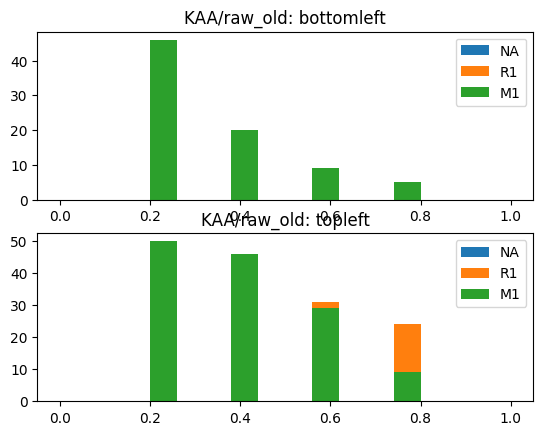

_ratios


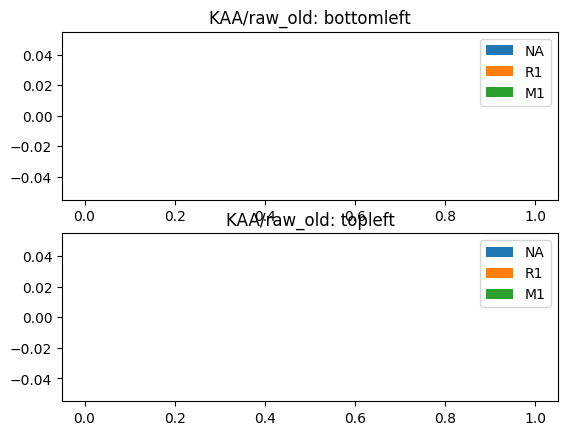

_intervals


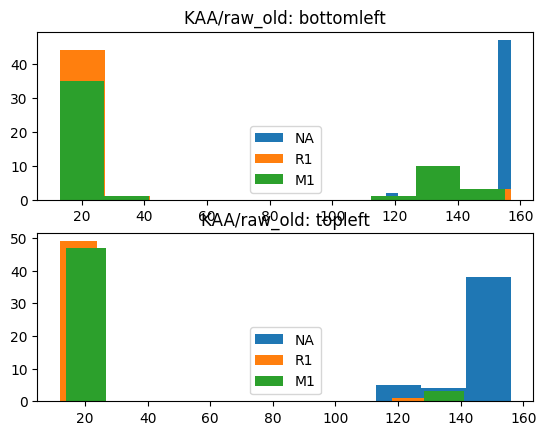

_peaks


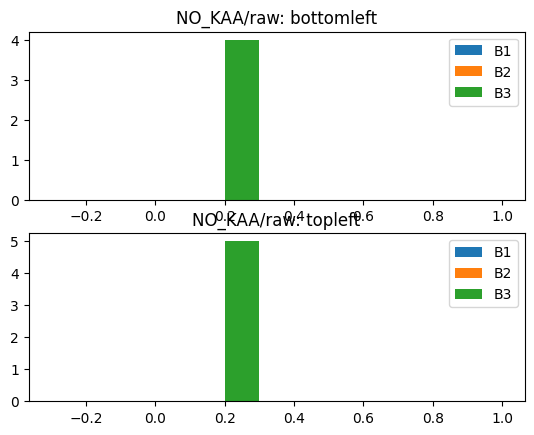

_ratios


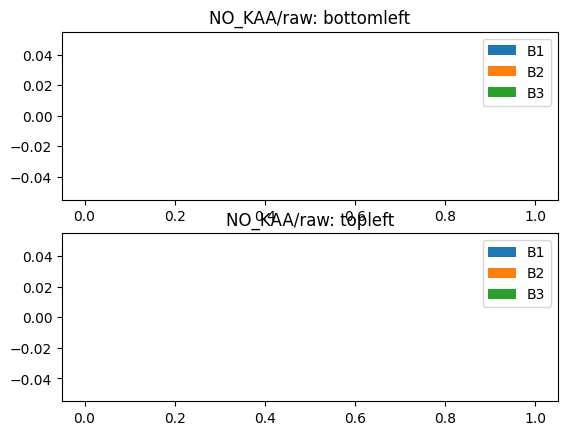

_intervals


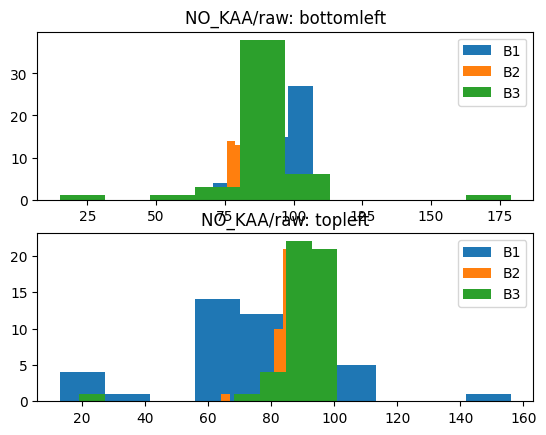

In [18]:
# for loc,_d in _intervals.items():
#     for k,v in _d.items():
#         plt.hist(v, label=k)
#     plt.legend()
#     plt.title(loc)
#     plt.show()
for folder,info in input_files.items():
    ppl, augs, locs = info
    for pers in ppl:
        pers_name, filetype = pers
        for feature_name, debug_features in zip(all_debug_features_names, all_debug_features):
            print(feature_name)
            # fig, axs = plt.subplots(len(debug_features[pers_name]))
            fig, axs = plt.subplots(2)
            for i, loc in enumerate(["bottomleft", "topleft"]):
                # print(loc)
                for aug in debug_features[pers_name][loc].keys():
                    features = debug_features[pers_name][loc][aug]
                    # print(features)
                    # print("ee")
                    axs[i].hist(features, label=aug)
                axs[i].legend()
                axs[i].set_title(f'{folder}: {loc}')
            fig.set_dpi(100)
            plt.show()

# Training and Evaluation

Using the KAP dataset:
- [find accuracy with no LOO (90% dataset for training)](KAP-NO-LOO)
- [find accuracy with LOO](KAP-LOO)
- [find accuracy with just FFT (no KAFE) with LOO](KAP-FFT)

Using the NO_KAA dataset:
- [find accuracy with just FFT (no KAFE) with LOO](NO-KAA-FFT)

In [19]:
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tuning import svmTuning
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# # GLOBAL VARS
# locations = ["middle", "topright", "bottomright", "bottomleft", "topleft"]
# # locations = ['middle']
# locs = locations
# # augments = ["NA", "R1", "R2", "M1", "M2"]
# augments = ["NA", "R1", "M1"]
# people = ppl.copy()
# # people.remove("MP5")

# # WHOLE DATASET
# location_variance = {}
all_ffts = dict()
all_features = dict()
for folder,info in input_files.items():
    ppl, augs, locs = info
    augment_keys = {k:n for n,k in enumerate(augs)}
    for pers in ppl:
        pers_name, filetype = pers
        all_features[pers_name] = dict()
        all_ffts[pers_name] = dict()
        d = all_features[pers_name]
        d2 = all_ffts[pers_name]
        for loc in locs:
            all_features[pers_name][loc] = dict()
            all_ffts[pers_name][loc] = dict()
            for aug in augs:
                _arr = np.load(f"{folder}/{pers_name}_{aug}_{loc}_features.npy")
                _fft = np.load(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy")
                
                # print(f"{folder}/{pers_name}_{aug}_{loc}_fft.npy")
                # print(_fft.shape)
                if _arr.shape[0] == 0:
                    print(f"{folder}/{pers_name}_{aug}_{loc}_features.npy")
                scaler = StandardScaler().set_output(transform="pandas")
                # scale data
                _arr = scaler.fit_transform(_arr)
                # _fft = scaler.fit_transform(_fft)
                # add labels
                _arr = np.c_[_arr, np.ones(_arr.shape[0])*augment_keys[aug]]
                _fft = np.c_[_fft, np.ones(_fft.shape[0])*augment_keys[aug]]
                # print(_fft.shape)
                # assert that there are no missing features
                assert not np.isnan(_arr[:,7:]).any(), f"contains nan in {folder}/{pers_name}_{aug}_{loc}"
                # save to all_features
                d[loc][aug] = _arr
                d2[loc][aug] = _fft
            

# EXAMPLE: M1_ALL_AUGMENTS_ALL_LOCATIONS
def tune(X_train, y_train, X_test, y_test):
    '''tunes both with linear and rbf. For our purposese, only show rsvm_acc'''
    # maxes = np.argsort(dataset[:,102:-1])[-10:]
    # define classifers
    clf_lsvm = SVC(kernel = 'linear')
    clf_rsvm = SVC(kernel = 'rbf')
    
    # tune and print result (tuned_lsvm, tuned_rsvm, lsvm_acc, rsvm_acc)
    results = svmTuning(X_train, y_train, X_test, y_test, clf_lsvm, clf_rsvm, 3)
    # print(results[2:])
    return results

def get_dataset(d):
    '''return copy of the dataset'''
    dataset = []
    for loc in d.keys():
        for aug in d[loc].keys():
            dataset.extend(d[loc][aug])
    return np.array(dataset)

def get_dataset_location_picky(d, l):
    '''returns leave one out based on location of the dataset'''
    train = []
    test = []
    # print(d)
    # print(d.keys())
    for loc in d.keys():
        # print(l,loc)
        if l == loc:
            # print("=")
            for aug in d[loc].keys():
                test.extend(d[loc][aug])
        else:
            for aug in d[loc].keys():
                train.extend(d[loc][aug])
        # print(len(train), len(test))
        # print(train)
        # print(test)
    return np.array(train), np.array(test)


In [369]:
# checking
# all_ffts["KAA"]["middle"]["R1"][:,-1]
# rest_dataset, loc_dataset = get_dataset_location_picky(all_features[pers_name], loc)
# print(rest_dataset[:,-1], loc_dataset[:,-1])
# for i in all_ffts["no_KAA"]["middle"]["B1"]:
#     plt.plot(i)
#     plt.show()

## KAP NO LOO

In [21]:
# KAP no LOO (90% training) w/ f=(200,600)
# MP1 MP2...
kap_no_loo = list()
for pers_name in ["KAA"]:
    # print(person)
    for loc in all_features[pers_name]:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            # loc_dataset = get_dataset(all_features[person])

            rest_dataset, loc_dataset = get_dataset_location_picky(all_features[pers_name], loc)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            restX_train, restX_test, resty_train, resty_test = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=rest_dataset[:, -1])
            # print(locy_test)
            # print(loc_dataset[:, -1:])
            _, clf, _, acc = tune(np.concatenate((restX_train,locX_train)), np.concatenate((resty_train,locy_train)), locX_test, locy_test)
            # _, clf, _, acc = tune(locX_train, locy_train, locX_test, locy_test)
            _r.append(acc)
            # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        kap_no_loo.append(accuracy_results_percentage)
    # accuracy_results.append(accuracy_results_percentage)

['middle', 0.99, 0.02380476142847616]
['topright', 0.9666666666666668, 0.039440531887330765]
['bottomright', 0.9833333333333334, 0.02886751345948128]
['bottomleft', 1.0, 0.0]
['topleft', 0.9933333333333334, 0.02]


## KAP LOO

In [20]:
# KAP_LOO
kap_loo = list()
for pers_name in ["KAA"]:
    # print(person)
    for loc in all_features[pers_name]:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            rest_dataset, loc_dataset = get_dataset_location_picky(all_features[pers_name], loc)
            # total_size = len(rest_dataset) + len(loc_dataset)
            # X_train, _, y_train, _ = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
            #                                           train_size=percentage * total_size / len(rest_dataset))
            # _, X_test, _, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
            #                                         test_size=0.1 * total_size / len(loc_dataset))
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], locX_test, locy_test)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        kap_loo.append(accuracy_results_percentage)
# np.save("confusions_bottles.npy", confusions)
# np.save("results.npy", accuracy_results)


['middle', 0.8700000000000001, 0.09303523824635243]
['topright', 0.9166666666666667, 0.06280481227138925]
['bottomright', 0.8700000000000001, 0.061373175465073225]
['bottomleft', 0.4333333333333334, 0.0649786289653931]
['topleft', 1.0, 0.0]


In [ ]:
['middle', 0.8400000000000001, 0.08537498983243798]
['topright', 0.9400000000000001, 0.05537749241945382]
['bottomright', 0.7, 0.06831300510639733]
['bottomleft', 0.6766666666666665, 0.02380476142847616]
['topleft', 0.7933333333333333, 0.07859884081701067]

## KAP FFT

In [22]:
# KAP_FFT (no KAFE)
# checking
# for i in all_ffts["no_KAA"]["middle"]["B1"]:
#     plt.plot(i)
#     plt.show()
kap_fft = list()
for pers_name in ["KAA"]:
    # print(person)
    for loc in all_ffts[pers_name]:
        # print(pers_name, loc)
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            rest_dataset, loc_dataset = get_dataset_location_picky(all_ffts[pers_name], loc)
            rest_dataset = np.c_[np.abs(rest_dataset[:,:-1]),rest_dataset[:,-1:]]
            loc_dataset = np.c_[np.abs(loc_dataset[:,:-1]),loc_dataset[:,-1:]]
            # total_size = len(rest_dataset) + len(loc_dataset)
            # X_train, _, y_train, _ = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
            #                                           train_size=percentage * total_size / len(rest_dataset))
            # _, X_test, _, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
            #                                         test_size=0.1 * total_size / len(loc_dataset))
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            # plt.plot(rest_dataset[0,:-1])
            # plt.show()
            _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], locX_test, locy_test)
            # print(acc)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        kap_fft.append(accuracy_results_percentage)

['middle', 0.6199999999999999, 0.09910712498212335]
['topright', 0.6166666666666666, 0.0963212218453326]
['bottomright', 0.44333333333333336, 0.048419463487779826]
['bottomleft', 0.49333333333333335, 0.09285592184789411]
['topleft', 0.5466666666666666, 0.09092121131323905]


## NO KAA FFT

In [23]:
# NO-KAA-FFT (no KAFE)
no_kaa_fft = list()
for pers_name in ["no_KAA"]:
    # print(person)
    for loc in all_ffts[pers_name]:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            rest_dataset, loc_dataset = get_dataset_location_picky(all_ffts[pers_name], loc)
            rest_dataset = np.abs(rest_dataset)
            loc_dataset = np.abs(loc_dataset)
            # total_size = len(rest_dataset) + len(loc_dataset)
            # X_train, _, y_train, _ = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
            #                                           train_size=percentage * total_size / len(rest_dataset))
            # _, X_test, _, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
            #                                         test_size=0.1 * total_size / len(loc_dataset))
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], locX_test, locy_test)
            _r.append(acc)
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        no_kaa_fft.append(accuracy_results_percentage)

['middle', 0.6633333333333331, 0.06137317546507323]
['topright', 0.5533333333333332, 0.08717797887081345]
['bottomright', 0.73125, 0.07153451963912248]
['bottomleft', 0.7366666666666666, 0.08020806277010646]
['topleft', 0.38666666666666666, 0.07180219742846006]


## Graphing Results

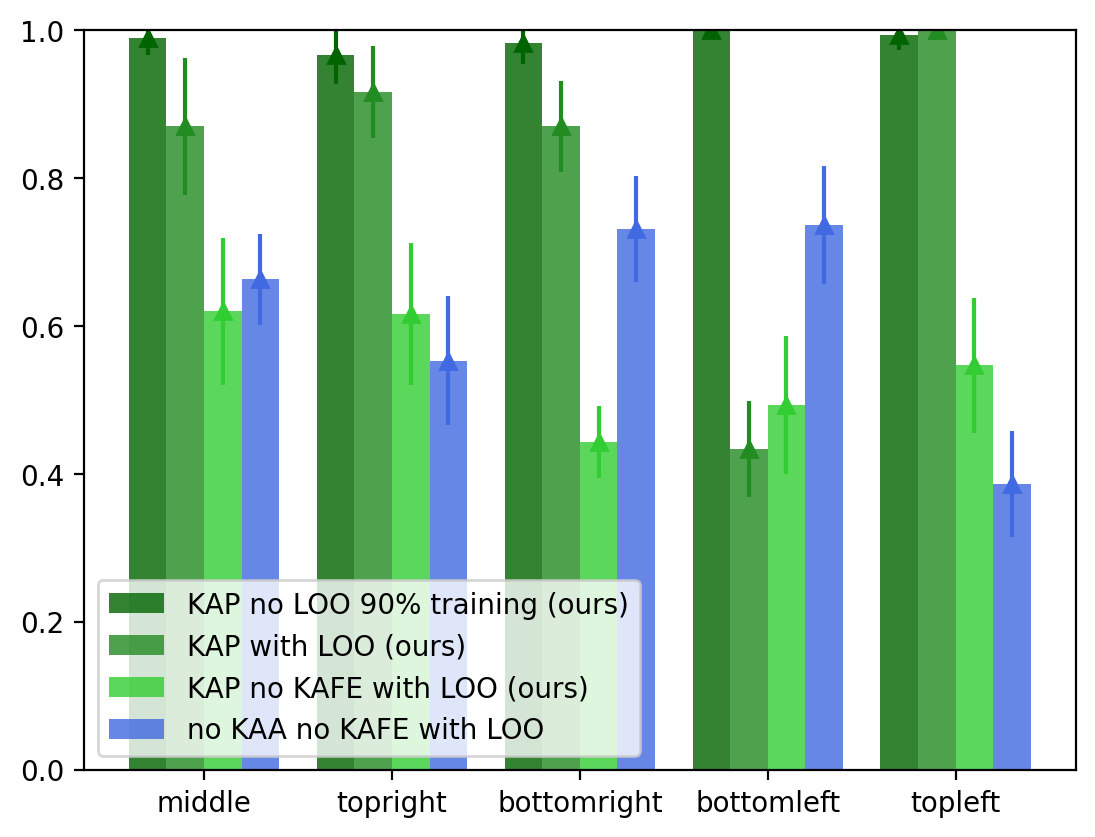

In [24]:
'''
Using the KAP dataset:
- [find accuracy with no LOO (90% dataset for training)](KAP-NO-LOO)
- [find accuracy with LOO](KAP-LOO)
- [find accuracy with just FFT (no KAFE) with LOO](KAP-FFT)

Using the NO_KAA dataset:
- [find accuracy with just FFT (no KAFE) with LOO](NO-KAA-FFT)
'''
all_results = {
    "KAP no LOO 90% training (ours)": (kap_no_loo, "darkgreen"),
    "KAP with LOO (ours)": (kap_loo, "forestgreen"),
    "KAP no KAFE with LOO (ours)": (kap_fft, "limegreen"),
    "no KAA no KAFE with LOO": (no_kaa_fft, "royalblue")
}

fig, ax = plt.subplots()
width = 0.20  # the width of the bars

for i,results in enumerate(all_results.keys()):
    color = all_results[results][1]
    locs = [all_results[results][0][multi][0] for multi in range(5)]
    avg = [all_results[results][0][multi][1]for multi in range(5)]
    std = [all_results[results][0][multi][2]for multi in range(5)]
    # print(i)
    offset = width * i
    # print(all_results[results], multi)
    rects = ax.bar(np.arange(5) + offset, avg, width, label=results, alpha= 0.8, color=color)
    ax.errorbar(np.arange(5) + offset, avg, std, linestyle='None', marker='^', c=color)
    ax.set_xticks(np.arange(5) + (width * 1.5), locs)
ax.legend(loc='lower left', ncols=1)
fig.dpi = 200
ax.set_ylim(0,1)
plt.savefig("results3.pdf")
plt.show()
        

In [ ]:
accuracy_results = list()
confusions = list()
for percentage in np.arange(0.1, 0.9, 0.2):
    percentage = np.round(percentage, 1)
    print(percentage)
    for loc in locs:
        _r = list()
        for _i in range(20):
            for person in people:
                # print(percentage, _i, bottle)
                loc_dataset = get_dataset(location_variance[person])
                total_size = len(rest_dataset) + len(loc_dataset)
                X_train, X_test, y_train, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                          train_size=percentage, test_size=1)
                _, clf, _, acc = tune(X_train, y_train, X_test, y_test)
                _r.append(acc)
                confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [percentage, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        accuracy_results.append(accuracy_results_percentage)

In [ ]:
percentage = np.round(0.9, 1)
print(percentage)
for loc in locs:
    _r = list()
    for _i in range(20):
        for person in people:
            # print(percentage, _i, bottle)
            loc_dataset = get_dataset(location_variance[person])
            total_size = len(rest_dataset) + len(loc_dataset)
            X_train, X_test, y_train, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=percentage, test_size=1)
            _, clf, _, acc = tune(X_train, y_train, X_test, y_test)
            _r.append(acc)
            confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
    accuracy_results_percentage = [percentage, np.average(_r), np.std(_r)]
    print(accuracy_results_percentage)
    accuracy_results.append(accuracy_results_percentage)

In [ ]:
percentage = np.round(0.9, 1)
print(percentage)
for loc in locs:
    _r = list()
    for _i in range(20):
        for person in people:
            # print(percentage, _i, bottle)
            loc_dataset = get_dataset(location_variance[person])
            total_size = len(loc_dataset)
            X_train, X_test, y_train, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=percentage, test_size=1)
            _, clf, _, acc = tune(X_train, y_train, X_test, y_test)
            _r.append(acc)
            # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
    accuracy_results_percentage = [percentage, np.average(_r), np.std(_r)]
    print(accuracy_results_percentage)
    # accuracy_results.append(accuracy_results_percentage)

In [ ]:
import pickle
percentage = np.round(1.0, 1)
print(percentage)
X = list()
y = list()
for loc in locs:
    _r = list()
    for person in people:
        # print(percentage, _i, bottle)
        loc_dataset = get_dataset(location_variance[person])
        # total_size = len(rest_dataset) + len(loc_dataset)
        X_train, y_train = loc_dataset[:, :-1], loc_dataset[:, -1]
        X.extend(X_train)
        y.extend(y_train)
_, clf, _, acc = tune(X, y, X, y)
_r.append(acc)
# print()
with open("model.pickle", "wb") as f:
    print(clf)
    pickle.dump(clf, f)
# confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
accuracy_results_percentage = [percentage, np.average(_r), np.std(_r)]
print(accuracy_results_percentage)
# accuracy_results.append(accuracy_results_percentage)

In [ ]:
with open("model.pickle", "rb") as f:
    clf = pickle.load(f)
clf.predict(X)

In [ ]:
# GLOBAL VARS
prefix = "Mix_2_ALL_Features"
locations = ["middle", "topright", "bottomright", "bottomleft", "topleft"]
locs = locations
# augments = ["NA", "R1", "R2", "M1", "M2"]
augments = ["NA", "R1", "M1"]
augment_keys = {k:n for n,k in enumerate(augments)}
people = ppl.copy()
people.remove("MP5")
# KAP no LOO (90% training)
# MP1 MP2...
for person in ["MP1", "Dong1"]:
    print(person)
    for loc in locs:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            # loc_dataset = get_dataset(location_variance[person])

            rest_dataset, loc_dataset = get_dataset_location_picky(location_variance[person], loc)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            restX_train, restX_test, resty_train, resty_test = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=rest_dataset[:, -1])
            # print(locy_test)
            # _, clf, _, acc = tune(np.concatenate((restX_train,locX_train)), np.concatenate((resty_train,locy_train)), locX_test, locy_test)
            _, clf, _, acc = tune(locX_train, locy_train, locX_test, locy_test)
            _r.append(acc)
            # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
    # accuracy_results.append(accuracy_results_percentage)

In [ ]:
# GLOBAL VARS
# people.remove("MP5")
# KAP no LOO (90% training)
# MP1 MP2...
for person in ["Dong1"]:
    print(person)
    for loc in locs:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            # loc_dataset = get_dataset(location_variance[person])

            rest_dataset, loc_dataset = get_dataset_location_picky(location_variance[person], loc)
            # print(loc_dataset)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            restX_train, restX_test, resty_train, resty_test = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=rest_dataset[:, -1])
            # print(locy_test)
            _, clf, _, acc = tune(np.concatenate((restX_train,locX_train)), np.concatenate((resty_train,locy_train)), locX_test, locy_test)
            # _, clf, _, acc = tune(locX_train, locy_train, locX_test, locy_test)
            _r.append(acc)
            # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
    # accuracy_results.append(accuracy_results_percentage)

In [ ]:
# KAP no LOO (90% training)
# MP1 MP2...
for person in ["THREE"]:
    print(person)
    for loc in locs:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            # loc_dataset = get_dataset(location_variance[person])

            rest_dataset, loc_dataset = get_dataset_location_picky(location_variance[person], loc)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            # restX_train, restX_test, resty_train, resty_test = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                                                      # train_size=0.9, random_state=_i, stratify=rest_dataset[:, -1])
            # print(locy_test)
            # _, clf, _, acc = tune(np.concatenate((restX_train,locX_train)), np.concatenate((resty_train,locy_train)), locX_test, locy_test)
            _, clf, _, acc = tune(locX_train, locy_train, locX_test, locy_test)
            _r.append(acc)
            # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
    # accuracy_results.append(accuracy_results_percentage)

In [ ]:

# KAP no LOO (90% training) w/ f=(200,600)
# MP1 MP2...
for person in ["Dong1"]:
    print(person)
    for loc in locs:
        _r = list()
        for _i in range(20):
            # print(percentage, _i, bottle)
            # loc_dataset = get_dataset(location_variance[person])

            rest_dataset, loc_dataset = get_dataset_location_picky(location_variance[person], loc)
            locX_train, locX_test, locy_train, locy_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=loc_dataset[:, -1])
            restX_train, restX_test, resty_train, resty_test = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                                                      train_size=0.9, random_state=_i, stratify=rest_dataset[:, -1])
            # print(locy_test)
            # _, clf, _, acc = tune(np.concatenate((restX_train,locX_train)), np.concatenate((resty_train,locy_train)), locX_test, locy_test)
            _, clf, _, acc = tune(locX_train, locy_train, locX_test, locy_test)
            _r.append(acc)
            # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
    # accuracy_results.append(accuracy_results_percentage)

In [ ]:
Dong1
['middle', 0.7, 0.0881917103688197]
['topright', 0.7699999999999998, 0.09769567259835231]
['bottomright', 0.8133333333333335, 0.09333333333333334]
['bottomleft', 0.9, 0.06146362971528591]
['topleft', 0.6933333333333335, 0.10413666234542207]
[0.1, 0.74, 0.0]
[0.1, 0.82, 0.0]
[0.1, 0.8523489932885906, 0.0]
[0.1, 0.38666666666666666, 0.0]
[0.1, 0.7466666666666667, 0.0]

In [ ]:
# KAP_LOO
accuracy_results = list()
confusions = list()
# percentage = 0.9
# print(percentage)
for person in people:
    print(person)
    for loc in locs:
        _r = list()
        for _i in range(20):
                # print(percentage, _i, bottle)
                rest_dataset, loc_dataset = get_dataset_location_picky(location_variance[person], loc)
                # total_size = len(rest_dataset) + len(loc_dataset)
                # X_train, _, y_train, _ = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                #                                           train_size=percentage * total_size / len(rest_dataset))
                # _, X_test, _, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                #                                         test_size=0.1 * total_size / len(loc_dataset))
                _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], loc_dataset[:, :-1], loc_dataset[:, -1])
                _r.append(acc)
                # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        accuracy_results.append(accuracy_results_percentage)
# np.save("confusions_bottles.npy", confusions)
# np.save("results.npy", accuracy_results)

In [ ]:
# KAP_LOO
accuracy_results = list()
confusions = list()
# percentage = 0.9
# print(percentage)
for person in people:
    print(person)
    for loc in locs:
        _r = list()
        for _i in range(20):
                # print(percentage, _i, bottle)
                rest_dataset, loc_dataset = get_dataset_location_picky(location_variance[person], loc)
                # total_size = len(rest_dataset) + len(loc_dataset)
                # X_train, _, y_train, _ = train_test_split(rest_dataset[:, :-1], rest_dataset[:, -1],
                #                                           train_size=percentage * total_size / len(rest_dataset))
                # _, X_test, _, y_test = train_test_split(loc_dataset[:, :-1], loc_dataset[:, -1],
                #                                         test_size=0.1 * total_size / len(loc_dataset))
                _, clf, _, acc = tune(rest_dataset[:, :-1], rest_dataset[:, -1], loc_dataset[:, :-1], loc_dataset[:, -1])
                _r.append(acc)
                # confusions.append(confusion_matrix(y_test, clf.predict(X_test)))
        accuracy_results_percentage = [loc, np.average(_r), np.std(_r)]
        print(accuracy_results_percentage)
        accuracy_results.append(accuracy_results_percentage)
# np.save("confusions_bottles.npy", confusions)
# np.save("results.npy", accuracy_results)